In [1]:
!pip install transformers

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#@title import packages

import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans

import torch.nn as nn

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize, Resize, Compose, ToPILImage

```python 
    def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    This function rescale the image's pixel intensity range. 
    e.g. original  
    [[ 34,  89, 200],
    [123, 178, 255],
    [ 12,  45, 100]]
    after rescaling : 
    [[0.133, 0.349, 0.784],
    [0.482, 0.698, 1.000],
    [0.047, 0.176, 0.392]]
```
why use it for the first step :
1. Smoother gradients: Using values ​​of [0, 1] helps prevent exploding or vanishing gradients, thus improving the training stability of the model.
2. Faster convergence: When the input data range is smaller, the neural network can converge faster, that is, find the optimal solution faster, and the training efficiency is higher.

In [4]:
#@title Plotting functions

import argparse
import torch
import matplotlib.pyplot as plt
import torchvision.transforms
from torch import nn
from torchvision import transforms
import torch.nn.modules.utils as nn_utils
import math
#import timm
import types
from pathlib import Path
from typing import Union, List, Tuple
from PIL import Image
from matplotlib.colors import ListedColormap

def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    r"""Rescale and displays an image represented as a img.
    The function scales the img :attr:`im` to the [0 ,1] range.
    The img is assumed to have shape :math:`3\times H\times W` (RGB)
    :math:`1\times H\times W` (grayscale).
    Args:
        img (:class:`torch.Tensor` or :class:`PIL.Image`): image.
        quiet (bool, optional): if False, do not display image.
            Default: ``False``.
        lim (list, optional): maximum and minimum intensity value for
            rescaling. Default: ``None``.
        interpolation (str, optional): The interpolation mode to use with
            :func:`matplotlib.pyplot.imshow` (e.g. ``'lanczos'`` or
            ``'nearest'``). Default: ``'lanczos'``.
    Returns:
        :class:`torch.Tensor`: Rescaled image img.
    """
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img)
    handle = None
    with torch.no_grad():
        if not lim:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            bitmap = img.expand(3,
                                *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
    return bitmap

def draw_correspondences(points1: List[Tuple[float, float]], points2: List[Tuple[float, float]],
                         image1: Image.Image, image2: Image.Image) -> Tuple[plt.Figure, plt.Figure]:
    """
    draw point correspondences on images.
    :param points1: a list of (y, x) coordinates of image1, corresponding to points2.
    :param points2: a list of (y, x) coordinates of image2, corresponding to points1.
    :param image1: a PIL image.
    :param image2: a PIL image.
    :return: two figures of images with marked points.
    """
    assert len(points1) == len(points2), f"points lengths are incompatible: {len(points1)} != {len(points2)}."
    num_points = len(points1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.axis('off')
    ax2.axis('off')
    #ax1.imshow(image1)
    #ax2.imshow(image2)
    ax1.imshow(imsc(image1))
    ax2.imshow(imsc(image2))

    if not points1:
      return fig

    if num_points > 15:
        cmap = plt.get_cmap('tab10')
    else:
        cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                               "maroon", "black", "white", "chocolate", "gray", "blueviolet"])
    colors = np.array([cmap(x) for x in range(num_points)])
    radius1, radius2 = 8, 1
    for point1, point2, color in zip(points1, points2, colors):
        y1, x1 = point1
        circ1_1 = plt.Circle((x1, y1), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x1, y1), radius2, facecolor=color, edgecolor='white')
        ax1.add_patch(circ1_1)
        ax1.add_patch(circ1_2)
        y2, x2 = point2
        circ2_1 = plt.Circle((x2, y2), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ2_2 = plt.Circle((x2, y2), radius2, facecolor=color, edgecolor='white')
        ax2.add_patch(circ2_1)
        ax2.add_patch(circ2_2)
    return fig

Shape: torch.Size([3, 223, 320]), Dtype: torch.float32
Shape: torch.Size([3, 375, 500]), Dtype: torch.float32


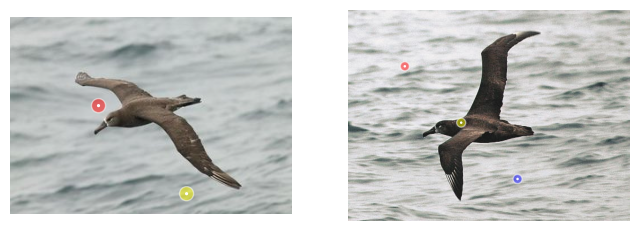

In [5]:
# This is the test code for above two functions : draw_correspondences and imsc
# It should display two images with points marked on them.
from PIL import Image
import matplotlib.pyplot as plt

image1 = Image.open('D:\\Github\\02456_Deep_Learning_Project\\data\\CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0001_796111.jpg')
image2 = Image.open('D:\\Github\\02456_Deep_Learning_Project\\data\\CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0003_796136.jpg')

# check the file path
# image1.show()
# image2.show()

image1_tensor = pil_to_tensor(image1).float()  # convert to tensor
image2_tensor = pil_to_tensor(image2).float()

print(f"Shape: {image1_tensor.shape}, Dtype: {image1_tensor.dtype}")
print(f"Shape: {image2_tensor.shape}, Dtype: {image2_tensor.dtype}")

points1 = [(100, 100), (200, 200), (300, 200)]
points2 = [(100, 100), (200, 200), (300, 300)]


fig = draw_correspondences(points1, points2, image1_tensor, image2_tensor)

plt.show()


In [6]:
#@title create dataset


from transformers import AutoProcessor, CLIPProcessor,CLIPVisionModelWithProjection


# CLIP Model for image, pre-processing
# processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
# Load the parts file
parts_file = '../data/CUB_200_2011/parts/parts.txt'
with open(parts_file, 'r', encoding='utf-8') as f:
    parts = [line.strip() for line in f.readlines()]


class CUB(Dataset):
    def __init__(self, base_path, train=True):

        self.base_path = base_path

        self.labels = pd.read_csv(''.join([base_path, 'image_class_labels.txt']), header=None, sep=" ", names=["id", "label"])
        self.train_test_split = pd.read_csv(''.join([base_path, 'train_test_split.txt']), header=None, sep=" ", names=["id", "is_train"])
        self.filenames = pd.read_csv(''.join([base_path, 'images.txt']), header=None, sep=" ")

        self.transforms = Compose([
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

        if train:
          mask = self.train_test_split.is_train.values == 1
        else:
          mask = self.train_test_split.is_train.values == 0

        self.filenames = self.filenames.iloc[mask]
        self.labels = self.labels[mask]

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):

        y = self.labels.iloc[index, 1] - 1
        file_name = self.filenames.iloc[index, 1]

        x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
        x = processor(images=x, return_tensors="pt")

        return x['pixel_values'].squeeze(), y

c:\Users\chens\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


variable x: tensor([[[ 0.9522,  0.9668,  0.9668,  ...,  0.3975,  0.3537,  0.3245],
         [ 0.9376,  0.9522,  0.9522,  ...,  0.3829,  0.3537,  0.3537],
         [ 0.9230,  0.9230,  0.9230,  ...,  0.3975,  0.3391,  0.3099],
         ...,
         [ 0.4997,  0.4559,  0.4413,  ..., -0.1864, -0.1864, -0.2010],
         [ 0.4705,  0.4559,  0.4413,  ..., -0.1864, -0.1718, -0.1718],
         [ 0.4997,  0.4705,  0.3975,  ..., -0.1718, -0.2010, -0.2156]],

        [[ 0.9343,  0.9493,  0.9643,  ...,  0.4991,  0.4540,  0.4240],
         [ 0.9193,  0.9493,  0.9493,  ...,  0.4841,  0.4540,  0.4540],
         [ 0.9193,  0.9193,  0.9193,  ...,  0.4991,  0.4540,  0.4240],
         ...,
         [ 0.6041,  0.5591,  0.5441,  ..., -0.1463, -0.1463, -0.1613],
         [ 0.5741,  0.5591,  0.5441,  ..., -0.1463, -0.1313, -0.1313],
         [ 0.6041,  0.5741,  0.4991,  ..., -0.1313, -0.1613, -0.1763]],

        [[ 0.8234,  0.8377,  0.8234,  ...,  0.2546,  0.2120,  0.1835],
         [ 0.8092,  0.8092,  0.82

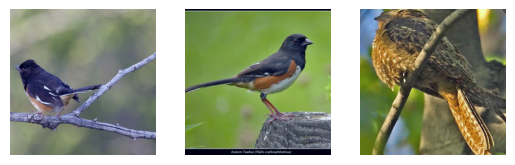

: 

In [ ]:
#@title dataset and dataloader and load samples

import random

# base_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/CUB_200_2011/CUB_200_2011/' # You need to change this.
base_path = '../data/CUB_200_2011/' # You need to change this.

train_dataset = CUB(base_path)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
#file_names, x, y = next(iter(train_loader))

random.seed(30)
inputs, labels = [], []
data_indices = []
#data_indices = random.sample(range(train_dataset.__len__()), 10)
# Here is where we pick the images to analyse. It is smart to pick one image from the same class and one from a different class.
# That generally gives more interesting results. The data is ordered, so class 1 starts from indices (0-30), class 2 from (30-60)
# and so on.

# data_indices.append(856)
# data_indices.append(858)
# data_indices.append(924)
# data_indices.append(29)
# data_indices.append(26)
# data_indices.append(50)

# data_indices.append(340)
# data_indices.append(344)
# data_indices.append(500)

# data_indices.append(210)
# data_indices.append(214)
# data_indices.append(242)

# data_indices.append(190)
# data_indices.append(194)
# data_indices.append(222)

# data_indices.append(900)
# data_indices.append(904)
# data_indices.append(932)
# data_indices.append(700)
# data_indices.append(704)
# data_indices.append(732)

data_indices.append(624)
data_indices.append(615)
data_indices.append(632)

for counter, data_idx in enumerate(data_indices):

  x, y = train_dataset.__getitem__(data_idx)
  print(f"variable x: {x}")
  print(f"variable y: {y}")

  #if counter == 0: x = query_transforms(x)

  inputs.append(x)
  labels.append(y)

print(labels)

plt.figure(1)
plt.subplot(131)
plt.imshow(imsc(inputs[0]))
plt.axis('off')
plt.subplot(132)
plt.imshow(imsc(inputs[1]))
plt.axis('off')
plt.subplot(133)
plt.imshow(imsc(inputs[2]))
plt.axis('off')
plt.show()


In [ ]:
#@title load model

from transformers import CLIPVisionConfig, CLIPVisionModel, CLIPModel, CLIPVisionModelWithProjection

# You can use the CLIPTextModel to process the text data once you get that far.
# see https://huggingface.co/docs/transformers/model_doc/clip#transformers.TFCLIPTextModel
# for more information.
# configuration = CLIPVisionConfig()
# model = CLIPVisionModel(configuration).to('cuda')
# model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch16").to('cuda')
# model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14").to('cuda')
# model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").to('cuda')
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to('cuda')
# model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").to('cuda')
# model = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-base-patch32").to('cuda')
vision_model = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-large-patch14").to('cuda')

# text_model = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to('cuda')


In [ ]:
#@title plot patches

print(f"inpus: {inputs}")
for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    # original permute(0,1,2) -> (C,H,W)
    print(f"img shape before: {img.shape}")
    img = img.permute(1, 2, 0)
    print(f"img shape after: {img.shape}")
    

    H, W, C = img.shape
    # new shape (H, W, C)
    print(f"img shape: {img.shape}")

    # create a random tensor with the same shape as the input image, batch size 1
    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    # dummy_input = img.unsqueeze(0).to('cuda')

    outputs = vision_model(dummy_input)  
    # outputs = model(pixel_values=img.unsqueeze(0).to('cuda'))  # 增加 batch 维度
    print(f"outputs: {outputs}")

    # 256 patches, 1024 features
    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    print(f"NUMBER_OF_PATCHES: {NUMBER_OF_PATCHES}")
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = vision_model.config.patch_size
    print("patch size is: ", PATCH_SIZE)
    # patch_width = 14, not 14, it should be 16
    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width
    # n_rows = 16, n_cols = 16

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]
    print(f"cropped_img shape: {cropped_img.shape}")
    

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    # create pathes 
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(5, 5))

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)



In [ ]:
#@title create patch embeddings

device='cuda'

embedings = []

with torch.no_grad():

    for counter, input_i in enumerate(inputs):

        input_i = input_i.to(device).unsqueeze(0)
        print(f"input shape:", input_i.shape)
        # vision model with input image
        outputs = vision_model(input_i, output_hidden_states=True)
        image_embeds = outputs.image_embeds
        # Extract and normalize the last_hidden_state
        hidden_states_in_last_layer = outputs.hidden_states[-1]
        print(hidden_states_in_last_layer.shape)
        projected_patches = vision_model.visual_projection(hidden_states_in_last_layer[0])
        print(projected_patches.shape)
        last_hidden_state_last_layer = nn.functional.normalize(projected_patches, p=2, dim=-1)
        # last_hidden_state: (batch_size, sequence_length, hidden_size)
        # embedings.append(outputs.last_hidden_state[0, 1:, :].numpy(force=True))
        # embedings.append(last_hidden_state_last_layer[0, 1:, :].cpu().numpy())
        embedings.append(last_hidden_state_last_layer[1:, :].cpu().numpy())
        print(f"embedding shape:",embedings[counter].shape)

# Load the parts file
parts_file = '../data/CUB_200_2011/parts/parts.txt'
with open(parts_file, 'r', encoding='utf-8') as f:
    parts = [line.strip() for line in f.readlines()]
    
print(parts)

from transformers import AutoTokenizer, CLIPTextModel,CLIPTextModelWithProjection
from torch.nn.functional import cosine_similarity


text_model = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-large-patch14").to(device)
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")


# Print the model device
print("Model device:", next(text_model.parameters()).device)

# Tokenize parts
text_inputs = tokenizer(parts, padding=True, return_tensors="pt")
text_inputs = {key: value.to(device) for key, value in text_inputs.items()}

new_outputs = text_model(**text_inputs, output_hidden_states=True)
print("new_outputs:", new_outputs)
# text_hidden_states_in_last_layer = new_outputs.hidden_states[-1]
# text_projected_patches = text_model.text_projection(text_hidden_states_in_last_layer[0])
# text_new_last_hidden_state = nn.functional.normalize(text_projected_patches, p=2, dim=-1)
# text_embeds = text_new_last_hidden_state
text_embeds = new_outputs.text_embeds
parts_embeddings = text_embeds
print(f"Parts embeddings shape: {parts_embeddings.shape}")


# Process each image's patch embeddings
matched_labels = []
for img_idx, patch_embedding in enumerate(embedings):
    patch_embedding = torch.tensor(patch_embedding, device=device) # Shape: (num_patches, 768) 
    print(f"Patch embedding shape: {patch_embedding.shape}")
    # projected_patch_embedding = projection_layer(patch_embedding)  
    # print(f"Projected patch embedding shape: {projected_patch_embedding.shape}")
    # Calculate cosine similarity between each patch and each part
    similarity_matrix = cosine_similarity(
        patch_embedding.unsqueeze(1),             # Shape: (num_patches, embedding_dim)
        parts_embeddings.unsqueeze(0),            # Shape: (num_parts, embedding_dim)
        dim=-1                                    # compute the cosine similarity along the last dimension
    )
    print(f"Similarity matrix shape: {similarity_matrix.shape}")
    
    # Find the part with the highest similarity for each patch
    best_match_indices = similarity_matrix.argmax(dim=1)  # Shape: (num_patches,)
    print(f"Best match indices : {best_match_indices}")
    print(f"Best match indices shape: {best_match_indices.shape}")
    labels = [parts[idx] for idx in best_match_indices]  # every image has 49 patches, each patch has a label
    matched_labels.append(labels)  # append the patch labels for each image
    
# print the matched labels for each image
for img_idx, labels in enumerate(matched_labels):
    print(f"Image {img_idx}: Matched labels for patches:")
    for patch_idx, label in enumerate(labels):
        print(f"  Patch {patch_idx}: {label}")

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def normalize_image(image):
    """Normalize the image to [0, 1] range for visualization."""
    return (image - image.min()) / (image.max() - image.min())

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def calculate_patch_coordinates(image, patch_size):
    """
    calculate the coordinates of the top-left corner of each patch.
    
    Args:
    - image (torch.Tensor) : input image, shape (C, H, W).
    - patch_size (int): size of each patch.

    Returns:
    - patch_coords (list): the top-left coordinates of each patch (x, y).
    """
    _, H, W = image.shape
    n_rows = H // patch_size
    n_cols = W // patch_size

    patch_coords = []
    for i in range(n_rows):
        for j in range(n_cols):
            x = j * patch_size
            y = i * patch_size
            patch_coords.append((x, y))
    return patch_coords

def visualize_patches_with_coordinates(image, patch_coords, matched_labels, patch_size=16):
    """
    use the precomputed coordinates and labels to annotate each patch.

    Args:
    - image (torch.Tensor): input image, shape (C, H, W).
    - patch_coords (list): every patch's top-left corner coordinates.
    - matched_labels (list): labels for each patch.
    - patch_size (int): size of each patch.
    """
    image = image.permute(1, 2, 0).cpu().numpy()  # transform the image to (H, W, C)
    image = (image - image.min()) / (image.max() - image.min())  # normalize the image to [0, 1]

    # debug information
    print(f"Number of patches: {len(patch_coords)}")
    print(f"Number of labels: {len(matched_labels)}")
    print(f"Patches coordinates: {patch_coords}")
    print(f"Labels: {matched_labels}")

    # plot the figure
    plt.figure(figsize=(18, 18))
    plt.imshow(image)
    ax = plt.gca()

    # loop over all patch coordinates and labels
    for idx, ((x, y), label) in enumerate(zip(patch_coords, matched_labels)):
        print(f"Drawing patch {idx} at ({x}, {y}) with label '{label}'")  # 打印调试信息
        # draw a rectangle around the patch
        rect = patches.Rectangle(
            (x, y), patch_size, patch_size, linewidth=1, edgecolor='white', facecolor='none'
        )
        ax.add_patch(rect)
        
        # draw the label in the center of the patch
        plt.text(
            x + patch_size // 2, y + patch_size // 2, label,
            color="blue", fontsize=6, ha="center", va="center",
            bbox=dict(facecolor="white", alpha=0.5)
        )

    plt.axis("off")
    plt.title("Patch Labels Visualization")
    plt.show()


# visualize the patches with the matched labels for each image
patch_size = 14
for img_idx, (img, labels) in enumerate(zip(inputs, matched_labels)):
    print(f"Visualizing Image {img_idx}...")
    patch_coords = calculate_patch_coordinates(img, patch_size)  # calculate the patch coordinates
    visualize_patches_with_coordinates(img, patch_coords, labels, patch_size)




original code below

In [ ]:
#@title STEP 1: find best buddies

nearest_neighbor_query, distances_query = pairwise_distances_argmin_min(embedings[0], np.concatenate(embedings[1:]), axis=1, metric='cosine')
nearest_neighbor_prototypes, distances_prototype = pairwise_distances_argmin_min(embedings[0], np.concatenate(embedings[1:]), axis=0, metric='cosine')

best_buddies = nearest_neighbor_prototypes[nearest_neighbor_query] == np.arange(NUMBER_OF_PATCHES)

best_buddies_query_indices = np.where(best_buddies == True)[0]
best_buddies_prototypes_indices = nearest_neighbor_query[best_buddies]

print(best_buddies_query_indices)




In [ ]:
#@title plot patches with best buddies


for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    img = img.permute(1, 2, 0)

    H, W, C = img.shape

    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    outputs = vision_model(dummy_input)

    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = vision_model.config.patch_size

    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(5, 5))

    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

            if counter == 0:
                if n_rows*row_idx+col_idx in best_buddies_query_indices:
                  if best_buddies_prototypes_indices[best_buddy_counter] > NUMBER_OF_PATCHES:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                  else:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                  best_buddy_counter += 1

            if counter == 1:
                if n_rows*row_idx+col_idx in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

            if counter == 2:
                if (n_rows*row_idx+col_idx+NUMBER_OF_PATCHES) in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)




In [ ]:
# #@title STEP 2: find foreground and remove best buddies beloning to background

# from sklearn.decomposition import PCA

# pca = PCA(n_components=10)
# # The following variable is important for the thresholding. You either set it to 0 or 1.
# # In the more complete code this happens automatically as you will see later.
# pca_component_to_threshold = 1
# # pca_component_to_threshold = 0
# pca_features = pca.fit_transform(np.concatenate(embedings))

# threshold = np.mean(pca_features[:, pca_component_to_threshold])
# foreground_mask = pca_features[:, pca_component_to_threshold] > threshold+0.5*np.std(pca_features[:, pca_component_to_threshold])
# foreground_mask = np.array(foreground_mask).reshape(-1, NUMBER_OF_PATCHES)

# prototypes_foreground_new_coordinates = nearest_neighbor_prototypes[foreground_mask[1:].flatten()]
# prototypes_foreground_mask_new_coordinates = np.zeros(NUMBER_OF_PATCHES, dtype=bool)
# prototypes_foreground_mask_new_coordinates[prototypes_foreground_new_coordinates] = True

# print(sum(best_buddies))

# best_buddies = np.bitwise_and(best_buddies, foreground_mask[0])
# best_buddies = np.bitwise_and(best_buddies, prototypes_foreground_mask_new_coordinates)

# print(sum(best_buddies))

# best_buddies_query_indices = np.where(best_buddies == True)[0]
# best_buddies_prototypes_indices = nearest_neighbor_query[best_buddies]

# from sklearn.decomposition import PCA

# pca = PCA(n_components=10)
# pca_component_to_threshold = 0
# pca_features = pca.fit_transform(np.concatenate(embedings))

# # 计算阈值
# threshold_mean = np.mean(pca_features[:, pca_component_to_threshold])
# threshold_std = 0.5 * np.std(pca_features[:, pca_component_to_threshold])

# # 生成前景掩码：大于阈值表示前景
# foreground_mask = pca_features[:, pca_component_to_threshold] < threshold_mean + threshold_std

# # 生成背景掩码：小于阈值表示背景
# background_mask = pca_features[:, pca_component_to_threshold] > threshold_mean - threshold_std

# # 将掩码转化为二维形式
# foreground_mask = np.array(foreground_mask).reshape(-1, NUMBER_OF_PATCHES)
# background_mask = np.array(background_mask).reshape(-1, NUMBER_OF_PATCHES)

# # 获取新的前景补丁的坐标
# prototypes_foreground_new_coordinates = nearest_neighbor_prototypes[foreground_mask[1:].flatten()]
# prototypes_foreground_mask_new_coordinates = np.zeros(NUMBER_OF_PATCHES, dtype=bool)
# prototypes_foreground_mask_new_coordinates[prototypes_foreground_new_coordinates] = True

# # 获取新的背景补丁的坐标
# prototypes_background_new_coordinates = nearest_neighbor_prototypes[background_mask[1:].flatten()]
# prototypes_background_mask_new_coordinates = np.zeros(NUMBER_OF_PATCHES, dtype=bool)
# prototypes_background_mask_new_coordinates[prototypes_background_new_coordinates] = True

# # 更新 best_buddies
# print(f"Original best_buddies count: {sum(best_buddies)}")

# best_buddies = np.bitwise_and(best_buddies, foreground_mask[0])  # 前景过滤
# best_buddies = np.bitwise_and(best_buddies, prototypes_foreground_mask_new_coordinates)  # 仅保留前景相关的

# print(f"Filtered best_buddies count (foreground only): {sum(best_buddies)}")

# # 如果需要也可以处理背景相关的 best_buddies
# best_buddies_background = np.bitwise_and(best_buddies, background_mask[0])  # 背景过滤
# best_buddies_background = np.bitwise_and(best_buddies_background, prototypes_background_mask_new_coordinates)

# print(f"Filtered best_buddies count (background only): {sum(best_buddies_background)}")

# # 提取最终的查询索引和原型索引
# best_buddies_query_indices = np.where(best_buddies == True)[0]
# best_buddies_prototypes_indices = nearest_neighbor_query[best_buddies]

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
 
# 执行 PCA 分析
pca = PCA(n_components=10)
pca_features = pca.fit_transform(np.concatenate(embedings))
 
# 计算主成分解释的方差比率
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio: {explained_variance_ratio}")
 
# 动态判断主成分是否具有双峰分布
def check_bimodal_distribution(data, bins=30):
    """判断数据是否具有双峰分布"""
    hist, bin_edges = np.histogram(data, bins=bins)
    peaks = np.sum((hist[1:-1] > hist[:-2]) & (hist[1:-1] > hist[2:]))
    return peaks >= 2
 
# 绘制主成分分布直方图
for i in range(2):  # 只绘制前两个主成分
    plt.figure()
    plt.hist(pca_features[:, i], bins=30, alpha=0.7, color='blue', label=f'PC {i + 1}')
    plt.axvline(np.mean(pca_features[:, i]), color='red', linestyle='--', label='Mean')
    plt.title(f'Principal Component {i + 1} Distribution')
    plt.legend()
    plt.show()
    if check_bimodal_distribution(pca_features[:, i]):
        print(f"Principal Component {i + 1} shows bimodal distribution.")
 
# 选择与前景相关的主成分
if check_bimodal_distribution(pca_features[:, 0]):
    print("Using the first principal component for foreground/background separation.")
    pca_component_to_threshold = 1
elif check_bimodal_distribution(pca_features[:, 1]):
    print("Using the second principal component for foreground/background separation.")
    pca_component_to_threshold = 0
else:
    print("Defaulting to the first principal component.")
    pca_component_to_threshold = 0
 
# 计算阈值
threshold_mean = np.mean(pca_features[:, pca_component_to_threshold])
threshold_std = 0.5 * np.std(pca_features[:, pca_component_to_threshold])
 
# 生成前景掩码和背景掩码
foreground_mask = pca_features[:, pca_component_to_threshold] > threshold_mean + threshold_std
background_mask = pca_features[:, pca_component_to_threshold] < threshold_mean - threshold_std
 
# 将掩码转化为二维形式
foreground_mask = np.array(foreground_mask).reshape(-1, NUMBER_OF_PATCHES)
background_mask = np.array(background_mask).reshape(-1, NUMBER_OF_PATCHES)
 
# 获取前景补丁和背景补丁的坐标
prototypes_foreground_new_coordinates = nearest_neighbor_prototypes[foreground_mask[1:].flatten()]
prototypes_foreground_mask_new_coordinates = np.zeros(NUMBER_OF_PATCHES, dtype=bool)
prototypes_foreground_mask_new_coordinates[prototypes_foreground_new_coordinates] = True
 
prototypes_background_new_coordinates = nearest_neighbor_prototypes[background_mask[1:].flatten()]
prototypes_background_mask_new_coordinates = np.zeros(NUMBER_OF_PATCHES, dtype=bool)
prototypes_background_mask_new_coordinates[prototypes_background_new_coordinates] = True
 
# 更新 best_buddies
print(f"Original best_buddies count: {sum(best_buddies)}")
 
best_buddies = np.bitwise_and(best_buddies, foreground_mask[0])  # 前景过滤
best_buddies = np.bitwise_and(best_buddies, prototypes_foreground_mask_new_coordinates)  # 仅保留前景相关
 
print(f"Filtered best_buddies count (foreground only): {sum(best_buddies)}")
 
# 如果需要处理背景相关的 best_buddies
best_buddies_background = np.bitwise_and(best_buddies, background_mask[0])  # 背景过滤
best_buddies_background = np.bitwise_and(best_buddies_background, prototypes_background_mask_new_coordinates)
 
print(f"Filtered best_buddies count (background only): {sum(best_buddies_background)}")
 
# 提取查询和原型的索引
best_buddies_query_indices = np.where(best_buddies == True)[0]
best_buddies_prototypes_indices = nearest_neighbor_query[best_buddies]
 
# 输出调试信息
print(f"Best buddies query indices: {best_buddies_query_indices}")
print(f"Best buddies prototype indices: {best_buddies_prototypes_indices}")

In [ ]:
#@title plot patches with best buddies and background masked out


for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    img = img.permute(1, 2, 0)

    H, W, C = img.shape

    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    outputs = vision_model(dummy_input)

    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = vision_model.config.patch_size

    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(5, 5))

    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

            if counter == 0:
                if n_rows*row_idx+col_idx in best_buddies_query_indices:
                  if best_buddies_prototypes_indices[best_buddy_counter] > NUMBER_OF_PATCHES:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                  else:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                  best_buddy_counter += 1

            if counter == 1:
                if n_rows*row_idx+col_idx in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

            if counter == 2:
                if (n_rows*row_idx+col_idx+NUMBER_OF_PATCHES) in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)




In [ ]:
#@title STEP 3: cluster best buddies


NUMBER_OF_PAIRS = 5 # This determines the number of clusters

bb_query = embedings[0][best_buddies, :]
bb_prototypes = np.concatenate(embedings[1:])[nearest_neighbor_query[best_buddies], :]

bb_combined_patches = np.concatenate((bb_query, bb_prototypes), axis=1)
bb_combined_patches = bb_combined_patches / np.linalg.norm(bb_combined_patches, axis=1, keepdims=True)

kmeans = KMeans(n_clusters=NUMBER_OF_PAIRS, random_state=0, n_init=10).fit(bb_combined_patches)
indices_to_show = np.argmin(kmeans.transform(bb_combined_patches), axis=0)

indices_to_show = np.nonzero(best_buddies)[0][indices_to_show]
query_indices_to_show = np.arange(NUMBER_OF_PATCHES)[indices_to_show]
prototype_indices_to_show = nearest_neighbor_query[indices_to_show]


print(query_indices_to_show)
print(prototype_indices_to_show)


In [ ]:
#@title plot query and prototypes with keypoints

for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    img = img.permute(1, 2, 0)

    H, W, C = img.shape

    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    outputs = vision_model(dummy_input)

    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = vision_model.config.patch_size

    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(8, 8))

    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

            if counter == 0:
                if n_rows*row_idx+col_idx in query_indices_to_show:
                  if best_buddies_prototypes_indices[best_buddy_counter] > NUMBER_OF_PATCHES:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                    axs[row_idx, col_idx].text(0.0, 0.0, f"P2.{best_buddy_counter}")
                  else:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                    axs[row_idx, col_idx].text(0.4, 0.5, f"P1.{best_buddy_counter}")

                  best_buddy_counter += 1

            if counter == 1:
                if n_rows*row_idx+col_idx in prototype_indices_to_show:

                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    axs[row_idx, col_idx].text(0.3, 0.0, f"P1.{best_buddy_counter}")
                    best_buddy_counter += 1

            if counter == 2:
                if (n_rows*row_idx+col_idx+NUMBER_OF_PATCHES) in prototype_indices_to_show:

                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    axs[row_idx, col_idx].text(0.5, 0.5, f"P2.{best_buddy_counter}", horizontalalignment='center', verticalalignment='center')
                    best_buddy_counter += 1

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)




In [ ]:
for counter, img in enumerate(inputs):

    # 转换图像维度 (C, H, W) -> (H, W, C)
    img = img.permute(1, 2, 0)
    H, W, C = img.shape

    # 动态获取 PATCH_SIZE
    PATCH_SIZE = vision_model.config.patch_size  # 14
    n_rows = H // PATCH_SIZE
    n_cols = W // PATCH_SIZE

    # 裁剪图像以适配 PATCH_SIZE
    cropped_img = img[:n_rows * PATCH_SIZE, :n_cols * PATCH_SIZE, :]

    # 划分为 Patch
    patches = torch.empty(n_rows, n_cols, PATCH_SIZE, PATCH_SIZE, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, PATCH_SIZE, n_cols, PATCH_SIZE)
            .permute(0, 2, 1, 3)
        )

    # 可视化设置
    f, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):
            patch_idx = n_rows * row_idx + col_idx  # 当前 Patch 的索引
            axs[row_idx, col_idx].imshow(
                imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()])
            )

            # 遮蔽背景区域（使用 foreground_mask）
            if not foreground_mask[counter, patch_idx]:
                color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                color_shading[:, :, 0] = 128  # 灰色遮罩表示背景
                axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                continue

            # 添加文字标签到高亮区域并打印索引
            if counter == 0 and patch_idx in best_buddies_query_indices:
                label = matched_labels[counter][patch_idx]  # 从 `matched_labels` 获取匹配的标签
                text_label = f"Q: {label}"  # Query 标签
                axs[row_idx, col_idx].text(
                    PATCH_SIZE // 2, PATCH_SIZE // 2, text_label,
                    fontsize=8, color="white", bbox=dict(facecolor="green", alpha=0.6),
                    horizontalalignment="center", verticalalignment="center"
                )
                print(f"Query - Index: {patch_idx}, Label: {label}")  # 打印索引和标签

            elif counter == 1 and patch_idx in best_buddies_prototypes_indices:
                label = matched_labels[counter][patch_idx]  # 从 `matched_labels` 获取匹配的标签
                text_label = f"P: {label}"  # Prototype 标签
                axs[row_idx, col_idx].text(
                    PATCH_SIZE // 2, PATCH_SIZE // 2, text_label,
                    fontsize=8, color="white", bbox=dict(facecolor="blue", alpha=0.6),
                    horizontalalignment="center", verticalalignment="center"
                )
                print(f"Prototype - Index: {patch_idx}, Label: {label}")  # 打印索引和标签

            elif counter == 2 and (patch_idx + NUMBER_OF_PATCHES) in best_buddies_prototypes_indices:
                label = matched_labels[counter][patch_idx]  # 从 `matched_labels` 获取匹配的标签
                text_label = f"P2: {label}"  # 绿色 Prototype 标签
                axs[row_idx, col_idx].text(
                    PATCH_SIZE // 2, PATCH_SIZE // 2, text_label,
                    fontsize=8, color="white", bbox=dict(facecolor="green", alpha=0.6),
                    horizontalalignment="center", verticalalignment="center"
                )
                print(f"Green Prototype - Index: {patch_idx}, Label: {label}")  # 打印索引和标签

    # 移除坐标轴
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)

    # 显示最终结果
    plt.show()


In [ ]:
from typing import List, Tuple
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import ConnectionPatch
from matplotlib.colors import ListedColormap

def map_patch_to_pixel(idx: int, n_cols: int, patch_size: int) -> Tuple[int, int]:
    """
    Map patch index to pixel coordinates in the image.
    :param idx: The patch index.
    :param n_cols: Number of patches in a row.
    :param patch_size: Size of each patch in pixels.
    :return: (y, x) coordinates in the image.
    """
    row = idx // n_cols
    col = idx % n_cols
    y = row * patch_size
    x = col * patch_size
    return y, x

def draw_correspondences_with_labels(points1: List[Tuple[float, float]], 
                                     points2: List[Tuple[float, float]], 
                                     labels: List[str],
                                     image1: Image.Image, 
                                     image2: Image.Image) -> plt.Figure:
    """
    Draw part correspondences with labels between two images.
    
    :param points1: List of (y, x) coordinates on image1.
    :param points2: List of (y, x) coordinates on image2.
    :param labels: List of labels corresponding to the points (length must match `points1` and `points2`).
    :param image1: First PIL image (query).
    :param image2: Second PIL image (prototype).
    :return: A matplotlib figure showing the two images with marked correspondences and labels.
    """
    assert len(points1) == len(points2) == len(labels), \
        f"Mismatch in lengths: {len(points1)}, {len(points2)}, {len(labels)}"
    
    num_points = len(points1)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axes
    ax1.axis('off')
    ax2.axis('off')
    
    # Display images
    ax1.imshow(image1)
    ax2.imshow(image2)

    # Adjust the axes to match the image resolution
    ax1.set_xlim(0, image1.width)
    ax1.set_ylim(image1.height, 0)
    ax2.set_xlim(0, image2.width)
    ax2.set_ylim(image2.height, 0)
    
    # Generate colors for each correspondence
    cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", 
                           "orange", "cyan", "darkgreen", "maroon", "black", 
                           "white", "chocolate", "gray", "blueviolet"])
    colors = np.array([cmap(x % cmap.N) for x in range(num_points)])
    radius_outer, radius_inner = 5, 2  # Outer and inner circle sizes
    
    # Draw correspondences and labels
    for i, (point1, point2, label) in enumerate(zip(points1, points2, labels)):
        y1, x1 = point1
        y2, x2 = point2

        # Debug: Print coordinates for verification
        print(f"Point {i}: Image1 -> ({x1}, {y1}), Image2 -> ({x2}, {y2}), Label -> {label}")
        
        # Draw circles on the first image
        circ1_outer = plt.Circle((x1, y1), radius_outer, facecolor=colors[i], edgecolor='white', alpha=0.5)
        circ1_inner = plt.Circle((x1, y1), radius_inner, facecolor=colors[i], edgecolor='white')
        ax1.add_patch(circ1_outer)
        ax1.add_patch(circ1_inner)
        ax1.text(x1 + radius_outer, y1, label, fontsize=8, color='black', 
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        
        # Draw circles on the second image
        circ2_outer = plt.Circle((x2, y2), radius_outer, facecolor=colors[i], edgecolor='white', alpha=0.5)
        circ2_inner = plt.Circle((x2, y2), radius_inner, facecolor=colors[i], edgecolor='white')
        ax2.add_patch(circ2_outer)
        ax2.add_patch(circ2_inner)
        ax2.text(x2 + radius_outer, y2, label, fontsize=8, color='black', 
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        
        # Draw a line connecting the corresponding points
        line = ConnectionPatch((x1, y1), (x2 + image1.width, y2), coordsA='data', coordsB='data',
                               axesA=ax1, axesB=ax2, color=colors[i], lw=1.5, alpha=0.7)
        fig.add_artist(line)
    
    # Adjust layout
    plt.tight_layout()
    return fig

# # Prepare correspondence points and labels dynamically from matched_labels
valid_correspondences = []
for query_idx, prototype_idx in zip(query_indices_to_show, prototype_indices_to_show):
    if query_idx < len(matched_labels[0]) and prototype_idx < len(matched_labels[1]):
        query_coords = map_patch_to_pixel(query_idx, n_cols, PATCH_SIZE)  # 左图坐标
        prototype_coords = map_patch_to_pixel(prototype_idx, n_cols, PATCH_SIZE)  # 右图坐标
        valid_correspondences.append((
            query_coords,
            prototype_coords,
            matched_labels[0][query_idx]  # 标签
        ))

# Unpack data for visualization
query_points, prototype_points, labels = zip(*valid_correspondences)

# Denormalize the images (convert tensors back to images)
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3).to(inputs[0].device)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3).to(inputs[0].device)
denormalized_query = (inputs[0].permute(1, 2, 0) * std + mean).clamp(0, 1)
denormalized_prototype = (inputs[1].permute(1, 2, 0) * std + mean).clamp(0, 1)

# Convert to uint8 and create PIL images
query_image = Image.fromarray((denormalized_query.cpu().numpy() * 255).astype(np.uint8))
prototype_image = Image.fromarray((denormalized_prototype.cpu().numpy() * 255).astype(np.uint8))

# Draw the correspondences
fig = draw_correspondences_with_labels(
    points1=query_points,
    points2=prototype_points,
    labels=labels,
    image1=query_image,
    image2=prototype_image
)

# Display the figure
plt.show(fig)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from typing import List, Tuple

def map_patch_to_pixel(idx: int, n_cols: int, patch_size: int) -> Tuple[int, int]:
    """
    将补丁索引映射到图像中补丁的中心坐标。
    :param idx: 补丁的索引。
    :param n_cols: 每行的补丁数量。
    :param patch_size: 每个补丁的大小（像素）。
    :return: (y, x) 中心坐标。
    """
    row = idx // n_cols
    col = idx % n_cols
    y = row * patch_size + patch_size // 2  # 补丁顶部向下偏移半个补丁大小
    x = col * patch_size + patch_size // 2  # 补丁左侧向右偏移半个补丁大小
    return y, x

def draw_correspondences_with_labels_and_patches(points1: List[Tuple[float, float]], 
                                                 points2: List[Tuple[float, float]], 
                                                 labels: List[str],
                                                 image1: Image.Image, 
                                                 image2: Image.Image,
                                                 patch_size: int) -> plt.Figure:
    """
    在两张图像之间绘制补丁网格、关键点对应关系和标签。
    
    :param points1: 图像1中的 (y, x) 坐标列表。
    :param points2: 图像2中的 (y, x) 坐标列表。
    :param labels: 对应的标签列表（长度必须与 points1 和 points2 相同）。
    :param image1: 第一张图像（查询图像）。
    :param image2: 第二张图像（原型图像）。
    :param patch_size: 每个补丁的大小（像素）。
    :return: 一个 matplotlib 图像，显示两张图像以及补丁网格和标注的对应关系。
    """
    assert len(points1) == len(points2) == len(labels), \
        f"点数不匹配: {len(points1)}, {len(points2)}, {len(labels)}"
    
    # 为每个标签分配颜色
    label_colors = {label: plt.cm.tab10(i % 10) for i, label in enumerate(set(labels))}
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # fig, axes = plt.subplots(1, 2, figsize=(image1.width / 20, image1.height/20))
    ax1, ax2 = axes
    ax1.axis('off')
    ax2.axis('off')
    
    # 显示图像
    ax1.imshow(image1)
    ax2.imshow(image2)

    # 绘制补丁网格
    for ax, img in zip([ax1, ax2], [image1, image2]):
        n_rows = img.height // patch_size
        n_cols = img.width // patch_size
        
        # 设置坐标轴范围，避免网格线超出图像区域
        ax.set_xlim(0, img.width)
        ax.set_ylim(img.height, 0)  # 图像坐标系的 y 轴是从上到下
    
        for row in range(n_rows + 1):
            ax.axhline(y=row * patch_size, color='black', linewidth=0.5, alpha=0.7)
        for col in range(n_cols + 1):
            ax.axvline(x=col * patch_size, color='black', linewidth=0.5, alpha=0.7)

    label_positions = []  # 存储已有标签的边界框
    point_radius = 15  # 点的半径（与 markersize 对应）
    for point1, point2, label in zip(points1, points2, labels):
        y1, x1 = point1
        y2, x2 = point2
        color = label_colors[label]

        # 动态调整标签位置函数
        def adjust_label_position(x, y, label_positions, label_length, point_radius):
            # 初始标签偏移值，标签右移点的直径（点左右两侧）后再右移一定距离
            offset_x = point_radius *  + 1  # 避开点的直径
            offset_y = 0  # 默认不在垂直方向偏移
            bbox_width = label_length * 6  # 标签宽度，按每字符6像素估算
            bbox_height = 10  # 标签高度
            while any(
                abs((x + offset_x) - lx) < bbox_width and abs((y + offset_y) - ly) < bbox_height
                for lx, ly, lw, lh in label_positions
            ):
                offset_y += 1  # 遇到冲突，向下移动标签
            return x + offset_x, y + offset_y

        # 在第一个图像上绘制点和标签
        ax1.plot(x1, y1, 'o', markersize=point_radius, color=color)
        adjusted_x1, adjusted_y1 = adjust_label_position(x1, y1, label_positions, len(label), point_radius)
        ax1.text(adjusted_x1, adjusted_y1, label, fontsize=11, color='black', 
                bbox=dict(facecolor='white', alpha=0.4, edgecolor='none'))
        label_positions.append((adjusted_x1, adjusted_y1, len(label) * 6, 10))  # 保存标签边界框

        # 在第二个图像上绘制点和标签
        ax2.plot(x2, y2, 'o', markersize=point_radius, color=color)
        adjusted_x2, adjusted_y2 = adjust_label_position(x2, y2, label_positions, len(label), point_radius)
        ax2.text(adjusted_x2, adjusted_y2, label, fontsize=11, color='black', 
                bbox=dict(facecolor='white', alpha=0.4, edgecolor='none'))
        label_positions.append((adjusted_x2, adjusted_y2, len(label) * 6, 10))  # 保存标签边界框
    
    # 调整布局
    plt.tight_layout()
    return fig

# 数据准备和处理逻辑保持不变
valid_correspondences = []
for query_idx, prototype_idx in zip(query_indices_to_show, prototype_indices_to_show):
    if query_idx < len(matched_labels[0]) and prototype_idx < len(matched_labels[1]):
        query_coords = map_patch_to_pixel(query_idx, n_cols, PATCH_SIZE)  # 查询图像补丁中心坐标
        prototype_coords = map_patch_to_pixel(prototype_idx, n_cols, PATCH_SIZE)  # 原型图像补丁中心坐标
        valid_correspondences.append((
            query_coords,
            prototype_coords,
            matched_labels[0][query_idx]  # 标签来自查询图像
        ))

# 拆分数据以用于可视化
query_points, prototype_points, labels = zip(*valid_correspondences)

# 恢复图像的颜色（反标准化）
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3).to(inputs[0].device)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3).to(inputs[0].device)
denormalized_query = (inputs[0].permute(1, 2, 0) * std + mean).clamp(0, 1)
denormalized_prototype = (inputs[1].permute(1, 2, 0) * std + mean).clamp(0, 1)

# 转换为 uint8 并创建 PIL 图像
query_image = Image.fromarray((denormalized_query.cpu().numpy() * 255).astype(np.uint8))
prototype_image = Image.fromarray((denormalized_prototype.cpu().numpy() * 255).astype(np.uint8))

# 绘制图像
fig = draw_correspondences_with_labels_and_patches(
    points1=query_points,
    points2=prototype_points,
    labels=labels,
    image1=query_image,
    image2=prototype_image,
    patch_size=PATCH_SIZE
)

# 显示结果
plt.show(fig)
